In [29]:
pip install pandas numpy matplotlib seaborn scikit-learn openpyxl xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pd.options.display.max_columns = 200
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

FILE_PATH = "D:\spotify-analysis\Spotify_user_research.xlsx" 

try:
    df = pd.read_excel(FILE_PATH)
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print(f"ERROR: File not found at {FILE_PATH}. Please check the file name and path.")
    
df.columns = [c.strip() for c in df.columns]

# --- CLEANING & FEATURE ENGINEERING ---
print("\n--- Data Cleaning and Feature Engineering ---")

# 1. Target Variable: Simplify 'premium_sub_willingness'
df['premium_yes'] = df['premium_sub_willingness'].astype(str).str.lower().map(
    lambda x: 1 if 'yes' in x or 'willing' in x or 'continue' in x else 0
)

# 2. Normalize Subscription Plan
df['plan'] = df['spotify_subscription_plan'].astype(str).str.lower().str.replace('free (ad-supported)', 'free').str.split('-').str[0].str.strip()
df['plan'] = df['plan'].replace({'premium (paid subscription)': 'premium', 'individual plan':'individual', 'duo plan':'duo', 'family plan':'family', 'student plan':'student', 'none':'none'})

# 3. Primary Genre (take the first listed)
df['primary_genre'] = df['fav_music_genre'].astype(str).str.split(';|,').str[0].str.strip().str.title().replace({'None': 'Unknown'})

# Drop NaN target and fill others for consistency
df = df.dropna(subset=['premium_sub_willingness']) 
df.fillna({'primary_genre': 'Unknown', 'music_time_slot': 'Unknown'}, inplace=True)

df.to_csv("spotify_cleaned.csv", index=False)
print("Saved cleaned data snapshot: spotify_cleaned.csv")

df.head()


Data loaded successfully. Shape: (28546, 20)

--- Data Cleaning and Feature Engineering ---
Saved cleaned data snapshot: spotify_cleaned.csv
Saved cleaned data snapshot: spotify_cleaned.csv


,Age,Gender,spotify_usage_period,spotify_listening_device,spotify_subscription_plan,premium_sub_willingness,preffered_premium_plan,preferred_listening_content,fav_music_genre,music_time_slot,music_Influencial_mood,music_lis_frequency,music_expl_method,music_recc_rating,pod_lis_frequency,fav_pod_genre,preffered_pod_format,pod_host_preference,preffered_pod_duration,pod_variety_satisfaction,premium_yes,plan,primary_genre
0,35~60,Others,More than 2 years,Smartphone,Family Plan-Rs 179/month,Yes,Family Plan-Rs 179/month,Podcast,Pop,Afternoon,Sadness or melancholy,Once a week,Recommendations,5,Daily,Comedy,NaN,NaN,Short (less than 15 minutes),Satisfied,1,family,Pop
1,20~35,Male,6 months to 1 year,Smart speakers or voice assistants,Family Plan-Rs 179/month,No,Family Plan-Rs 179/month,Podcast,Rock,Morning,Social gatherings or parties,Rarely,Recommendations,1,Once a week,Technology,Discussion,Both,Short (less than 15 minutes),Dissatisfied,0,family,Rock
2,12~20,Female,More than 2 years,Computer or laptop,Free (ad-supported),No,Student Plan-Rs 59/month,Music,Pop,Morning,Relaxation and stress relief,Rarely,Recommendations,4,Several times a week,NaN,NaN,Both,Long (more than 30 minutes),Very Satisfied,0,free,Pop
3,12~20,Female,Less than 6 months,Computer or laptop,Student Plan-Rs 59/month,No,Individual Plan- Rs 119/month,Music,Rock,Night,Social gatherings or parties,Rarely,Playlists,5,Daily,NaN,NaN,Well known individuals,Medium (15-30 minutes),Satisfied,0,student,Rock
4,12~20,Male,1 year to 2 years,Smartphone,Individual Plan- Rs 119/month,Yes,NaN,Podcast,Pop,Evening,Social gatherings or parties,Once a week,Playlists,4,Rarely,NaN,Interview,Well known individuals,NaN,Very Satisfied,1,individual,Pop


C:\Users\Arnii Srivastava\AppData\Local\Temp\ipykernel_32332\4057638665.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='primary_genre', data=df, order=df['primary_genre'].value_counts().index[:10], palette="coolwarm")


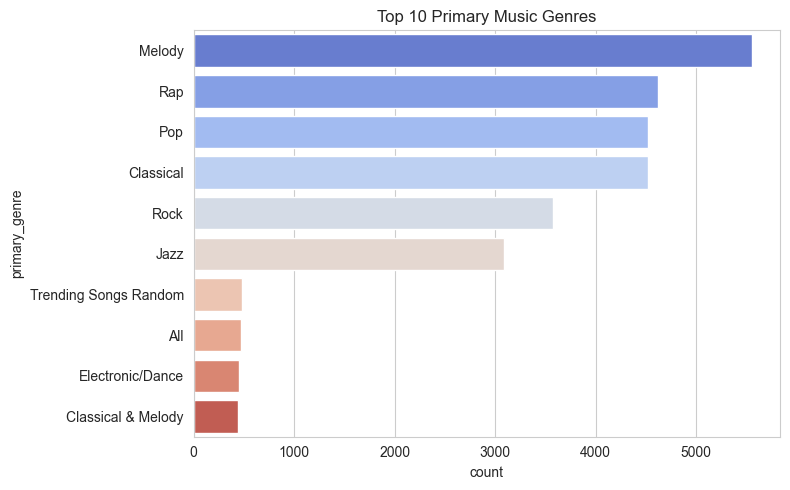

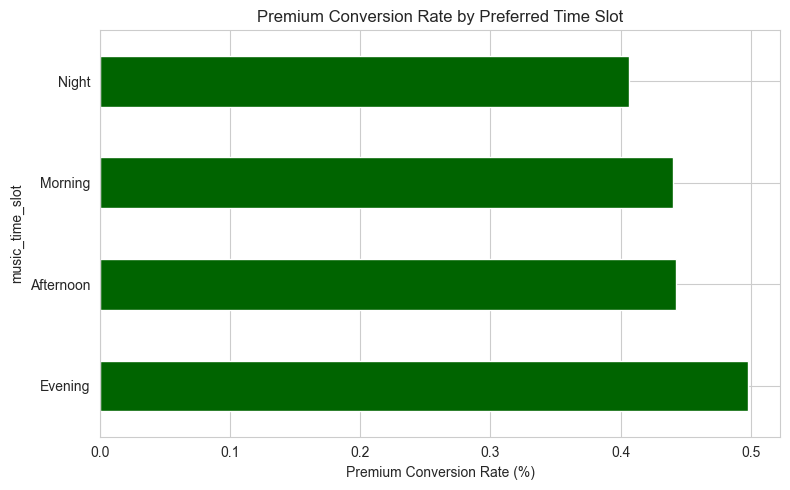

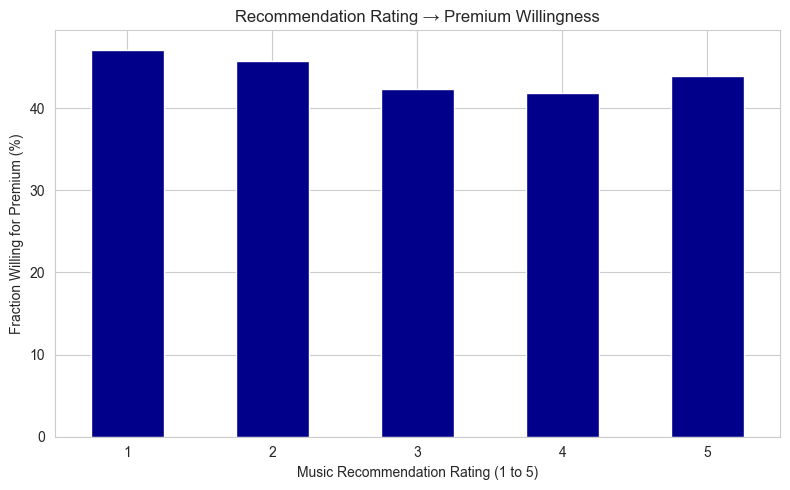

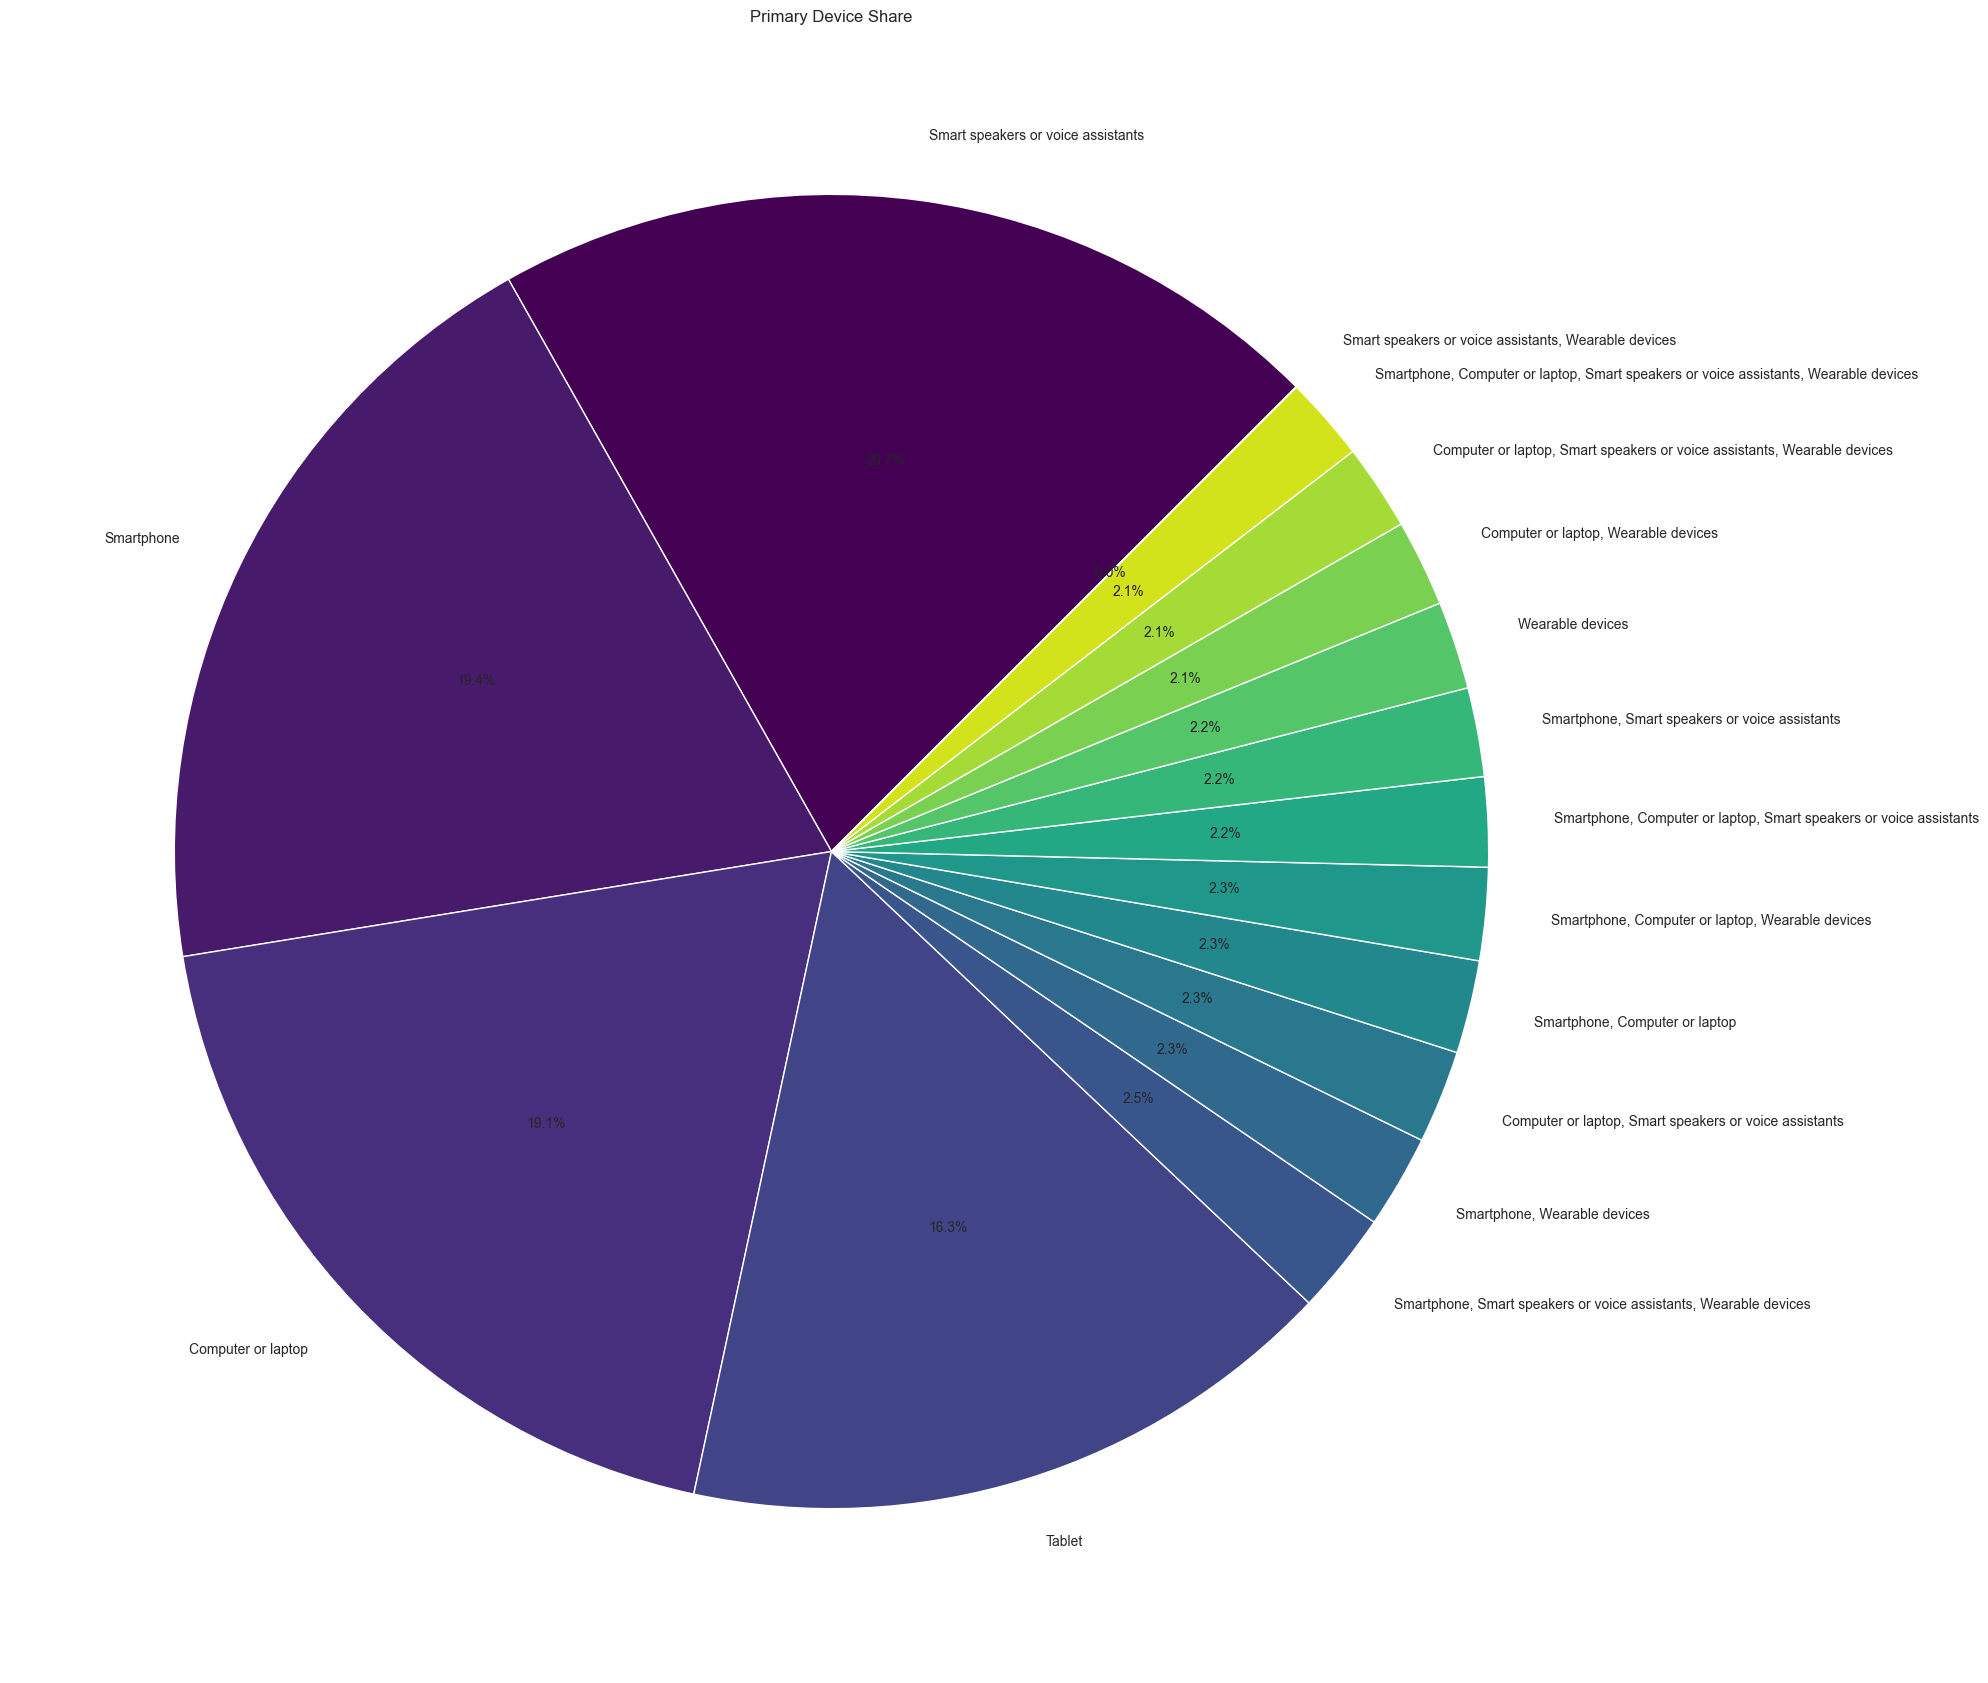

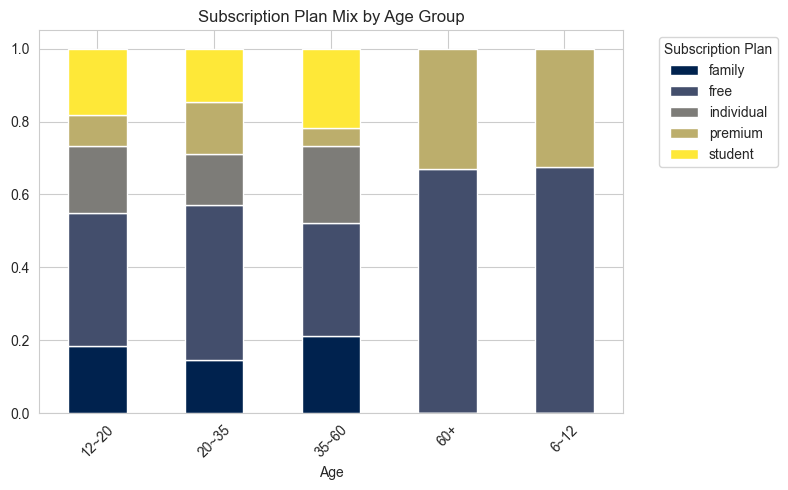

In [31]:
# --- 2. KEY AGGREGATIONS & VISUALS (PNG EXPORTS FOR DASHBOARD) ---

# 2.1. Top Genres (Content Strategy)
plt.figure(figsize=(8, 5))
sns.countplot(y='primary_genre', data=df, order=df['primary_genre'].value_counts().index[:10], palette="coolwarm")
plt.title("Top 10 Primary Music Genres")
plt.tight_layout()
plt.savefig("viz_top_genres.png")
plt.show()

# 2.2. Listening Time Slot vs Premium % (Monetization Timing)
slot = df.groupby('music_time_slot')['premium_yes'].mean().sort_values(ascending=False)
plt.figure(figsize=(8, 5))
slot.plot(kind='barh', color='darkgreen')
plt.title("Premium Conversion Rate by Preferred Time Slot")
plt.xlabel("Premium Conversion Rate (%)")
plt.tight_layout()
plt.savefig("viz_time_slot_premium.png")
plt.show()

# 2.3. Recommendation satisfaction vs premium (Product Quality)
rec_df = df[df['music_recc_rating'] >= 1] 
rec = pd.crosstab(rec_df['music_recc_rating'], rec_df['premium_yes'], normalize='index')[1] * 100
plt.figure(figsize=(8, 5))
rec.plot(kind='bar', color='darkblue')
plt.ylabel("Fraction Willing for Premium (%)")
plt.xlabel("Music Recommendation Rating (1 to 5)")
plt.title("Recommendation Rating → Premium Willingness")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("viz_rec_vs_premium.png")
plt.show()

# 2.4. Device preference (Mobile Focus)
plt.figure(figsize=(20,20))
df['spotify_listening_device'].value_counts().plot.pie(autopct='%1.1f%%', startangle=45, cmap='viridis')
plt.ylabel(""); plt.title("Primary Device Share"); plt.tight_layout()
plt.savefig("viz_devices.png")
plt.show()

# 2.5. Top age group and subscription mix (Pricing Strategy)
plt.figure(figsize=(8, 5))
pd.crosstab(df['Age'], df['plan'], normalize='index').plot(kind='bar', stacked=True, figsize=(8, 5), cmap='cividis', ax=plt.gca())
plt.title("Subscription Plan Mix by Age Group")
plt.xticks(rotation=45)
plt.legend(title='Subscription Plan', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("viz_plan_age.png")
plt.show()





--- 3.5. Model Comparison: Logistic Regression vs Random Forest vs XGBoost ---


c:\Users\Arnii Srivastava\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:03:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Logistic Regression:
  AUC: 0.5824
  Precision: 0.4888
  Recall: 0.2352
  F1-Score: 0.3176

Random Forest:
  AUC: 0.5418
  Precision: 0.4825
  Recall: 0.3854
  F1-Score: 0.4285

XGBoost:
  AUC: 0.5621
  Precision: 0.4838
  Recall: 0.3814
  F1-Score: 0.4265

MODEL COMPARISON SUMMARY
              Model      AUC  Precision   Recall  F1-Score
Logistic Regression 0.582382   0.488797 0.235224  0.317606
      Random Forest 0.541826   0.482500 0.385383  0.428508
            XGBoost 0.562093   0.483789 0.381390  0.426530


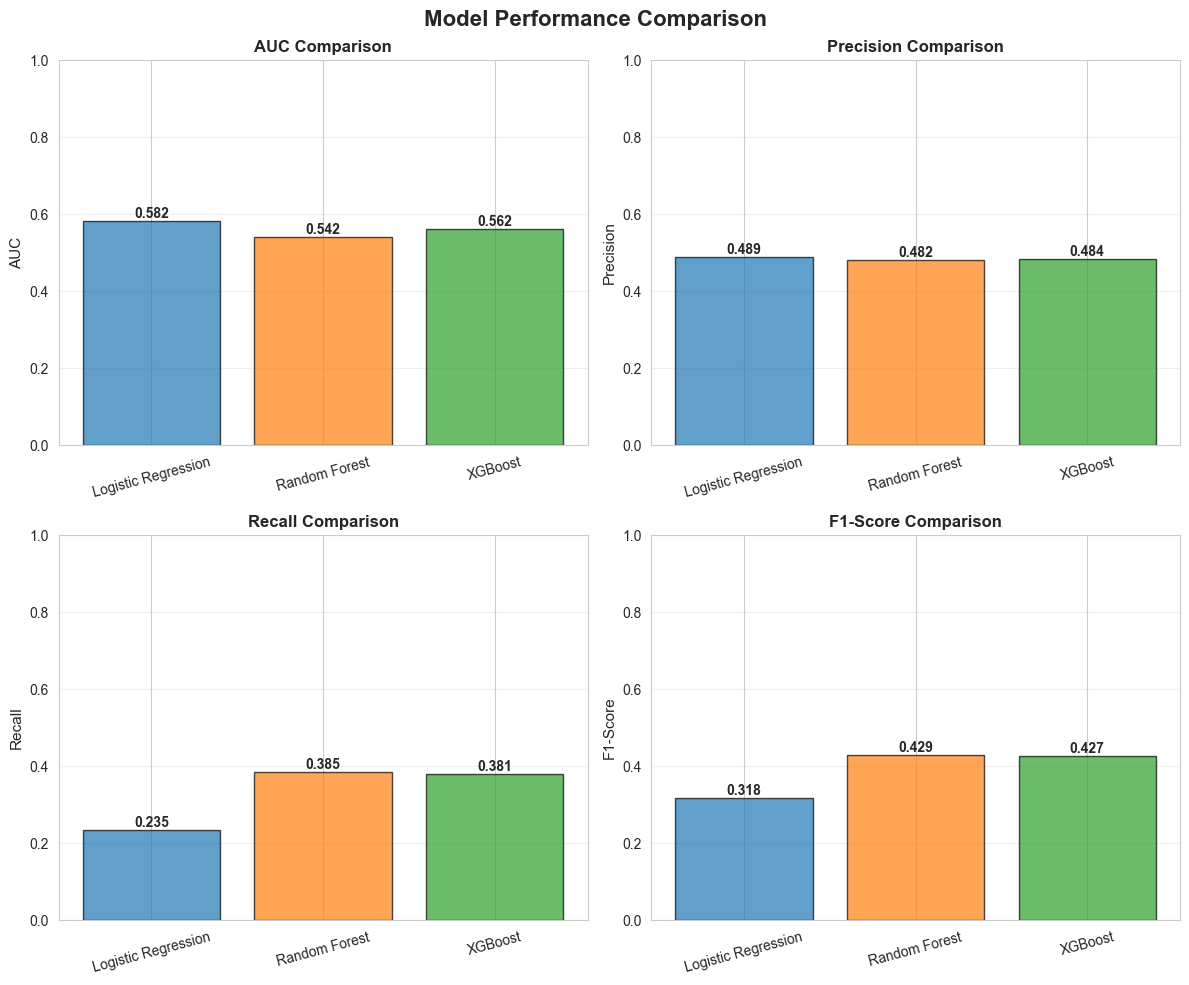


FEATURE IMPORTANCE: Random Forest vs XGBoost


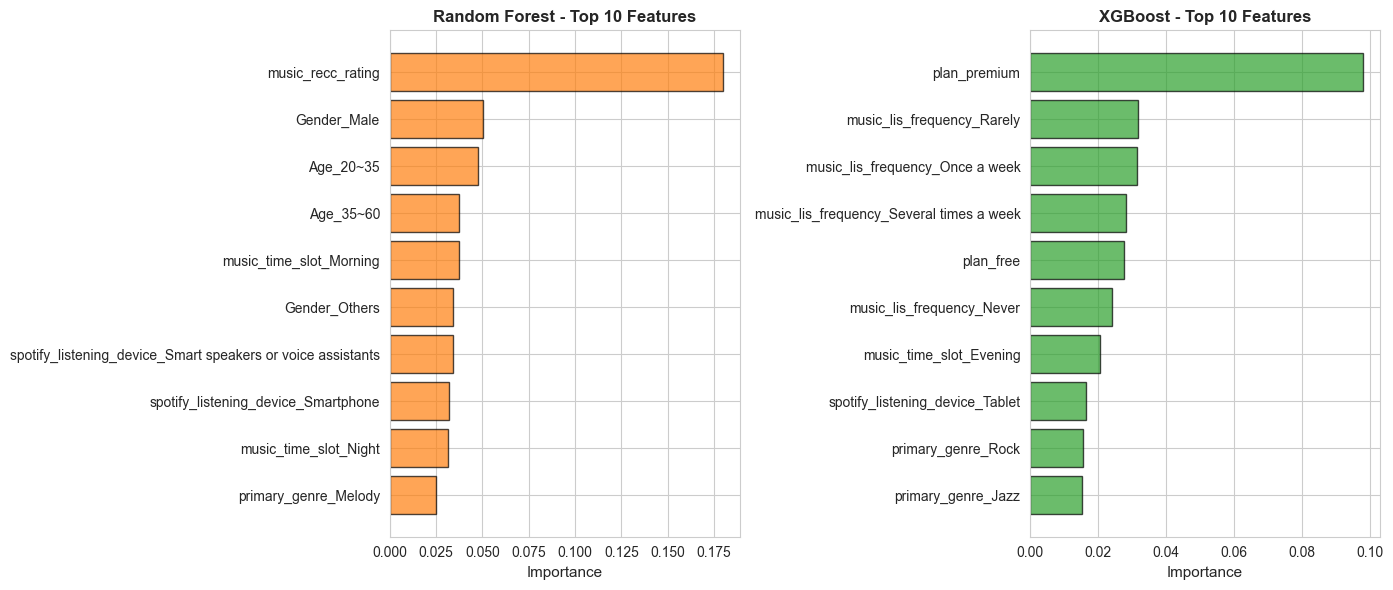


✓ Best Model by AUC: Logistic Regression (AUC: 0.5824)


In [32]:
# --- 3 MODEL COMPARISON: MULTIPLE ALGORITHMS ---

print("\n--- 3.5. Model Comparison: Logistic Regression vs Random Forest vs XGBoost ---")

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb

# Prepare data (reuse from previous model)
use_cols = ['Age', 'Gender', 'spotify_listening_device', 'plan', 'primary_genre', 'music_lis_frequency', 'music_recc_rating', 'music_time_slot']
df_model = df[use_cols + ['premium_yes']].copy()
df_model.fillna('Unknown', inplace=True)

X = pd.get_dummies(df_model.drop(columns='premium_yes'), drop_first=True)
y = df_model['premium_yes'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train multiple models
models = {}

# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
lr_model.fit(X_train, y_train)
models['Logistic Regression'] = lr_model

# 2. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model

# 3. XGBoost
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model

# Evaluate all models
results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })
    
    print(f"\n{name}:")
    print(f"  AUC: {auc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Create comparison DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(results_df.to_string(index=False))

# Visualization: Model Performance Comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['AUC', 'Precision', 'Recall', 'F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig("viz_model_comparison.png", dpi=100, bbox_inches='tight')
plt.show()

# Feature Importance Comparison (top models)
print("\n" + "="*70)
print("FEATURE IMPORTANCE: Random Forest vs XGBoost")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Feature Importance
rf_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
axes[0].barh(rf_importance.index, rf_importance.values, color='#ff7f0e', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Importance', fontsize=11)
axes[0].set_title('Random Forest - Top 10 Features', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# XGBoost Feature Importance
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
axes[1].barh(xgb_importance.index, xgb_importance.values, color='#2ca02c', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Importance', fontsize=11)
axes[1].set_title('XGBoost - Top 10 Features', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig("viz_feature_importance_comparison.png", dpi=100, bbox_inches='tight')
plt.show()

# Store best model
best_model_name = results_df.loc[results_df['AUC'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\n✓ Best Model by AUC: {best_model_name} (AUC: {results_df['AUC'].max():.4f})")



--- 3. Predictive Model: Premium Conversion Predictor ---
Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.81      0.67      3206
           1       0.49      0.24      0.32      2504

    accuracy                           0.56      5710
   macro avg       0.53      0.52      0.49      5710
weighted avg       0.54      0.56      0.52      5710

Model ROC AUC: 0.5824


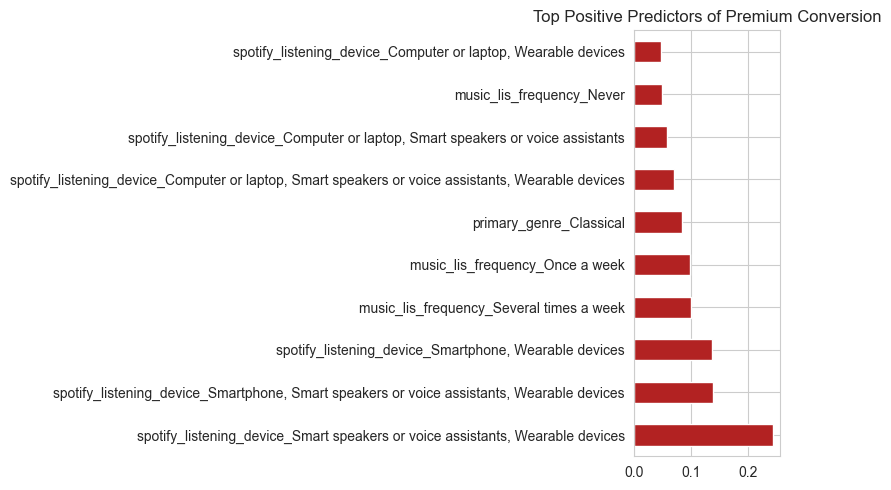

spotify_listening_device_Smart speakers or voice assistants, Wearable devices                        0.243530
spotify_listening_device_Smartphone, Smart speakers or voice assistants, Wearable devices            0.137137
spotify_listening_device_Smartphone, Wearable devices                                                0.136169
music_lis_frequency_Several times a week                                                             0.100037
music_lis_frequency_Once a week                                                                      0.097404
primary_genre_Classical                                                                              0.082723
spotify_listening_device_Computer or laptop, Smart speakers or voice assistants, Wearable devices    0.069763
spotify_listening_device_Computer or laptop, Smart speakers or voice assistants                      0.057533
music_lis_frequency_Never                                                                            0.048301
spotify_li

In [33]:
# --- 3.5 PREDICTIVE MODEL (Logistic Regression) ---

print("\n--- 3. Predictive Model: Premium Conversion Predictor ---")

# Features and target setup
use_cols = ['Age', 'Gender', 'spotify_listening_device', 'plan', 'primary_genre', 'music_lis_frequency', 'music_recc_rating', 'music_time_slot']
df_model = df[use_cols + ['premium_yes']].copy()
df_model.fillna('Unknown', inplace=True)

X = pd.get_dummies(df_model.drop(columns='premium_yes'), drop_first=True)
y = df_model['premium_yes'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:\n")
print(classification_report(y_test, y_pred))
model_auc = roc_auc_score(y_test, y_proba)
print(f"Model ROC AUC: {model_auc:.4f}")

# Feature Importance
coef = pd.Series(model.coef_[0], index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(8, 5))
coef.plot(kind='barh', color='firebrick')
plt.title('Top Positive Predictors of Premium Conversion')
plt.tight_layout()
plt.savefig("viz_feature_importance.png")
plt.show()
coef.head(10)




--- 4. K-Means Segmentation and Mapping ---

Segment Profiles (Premium Willingness, Age, Device):
|   segment |   Premium_Willingness | Modal_Age   | Modal_Device                       |
|----------:|----------------------:|:------------|:-----------------------------------|
|         0 |              0.491088 | 20~35       | Smartphone                         |
|         3 |              0.346667 | 20~35       | Wearable devices                   |
|         1 |              0.343035 | 20~35       | Smart speakers or voice assistants |
|         2 |              0.330381 | 20~35       | Smart speakers or voice assistants |


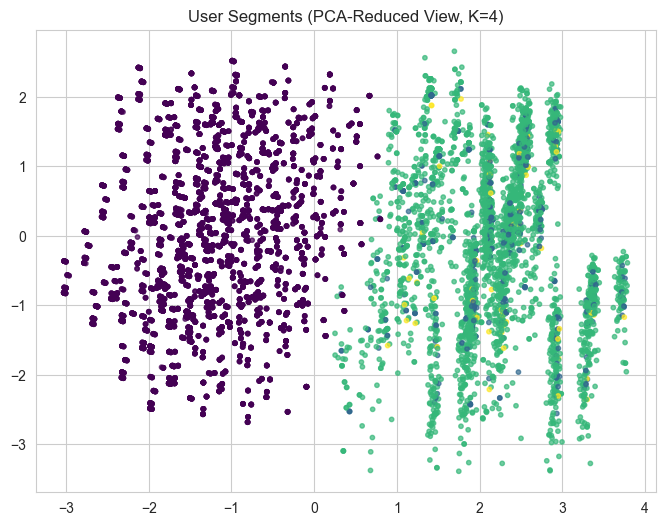


Exported 'spotify_cleaned_final.csv' to D:\spotify-analysis\spotify_cleaned_final.csv


In [34]:
# --- 4. CLUSTERING / SEGMENTATION (K-Means) ---

print("\n--- 4. K-Means Segmentation and Mapping ---")

# EDIT 1: Removed 'premium_yes' from features. Clustering should be based on behavior.
seg_features_cols = ['Age', 'spotify_listening_device', 'music_time_slot', 'music_lis_frequency', 'plan']
df_seg = df[seg_features_cols].copy()

# 1. One-hot encode the full dataset features
seg_features = pd.get_dummies(df_seg, drop_first=True)

# 2. Sample the features for faster computation
sample_size = 10000 
seg_features_sampled = seg_features.sample(n=sample_size, random_state=42) 

# 3. Scale and Fit K-Means
scaler = StandardScaler()
S = scaler.fit_transform(seg_features_sampled)
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10).fit(S)
seg = kmeans.labels_

# Mapping the labels back to the full DataFrame (df)

# 4. Create a Series with segment labels indexed by the sampled indices
segment_map = pd.Series(kmeans.labels_, index=seg_features_sampled.index)

# 5. Create the 'segment' column in the FULL dataframe (df) using the index map
#    Rows that were sampled get the segment ID (0, 1, 2, 3); all others get NaN.
df['segment'] = segment_map.astype('Int64') # Use Int64 to allow NaN/Null values

# 6. Create the final clean label column for Tableau:
df['segment_label'] = df['segment'].fillna(-1).astype(int).astype(str).replace(
    {'-1': 'Unsampled', '0': 'Segment 0', '1': 'Segment 1', '2': 'Segment 2', '3': 'Segment 3'}
)

# 7. Profile the segments (using the sampled index for aggregation)
sample = df.dropna(subset=['segment']).copy() # Only use the rows that were sampled/clustered
segment_profiles = sample.groupby('segment').agg(
    Premium_Willingness=('premium_yes', 'mean'),
    Modal_Age=('Age', lambda x: x.mode().iloc[0]),
    Modal_Device=('spotify_listening_device', lambda x: x.mode().iloc[0])
)
print("\nSegment Profiles (Premium Willingness, Age, Device):")
print(segment_profiles.sort_values(by='Premium_Willingness', ascending=False).to_markdown())

# PCA for Visualization
pca = PCA(2).fit_transform(S)
plt.figure(figsize=(8, 6))
plt.scatter(pca[:, 0], pca[:, 1], c=seg, cmap='viridis', s=10, alpha=0.7)
plt.title("User Segments (PCA-Reduced View, K=4)")
plt.savefig("viz_segments.png")
plt.show()

# --- FINAL EXPORT ---
import os
output_path = "D:\spotify-analysis\spotify_cleaned_final.csv"
try:
    df.to_csv(output_path, index=False)
    print(f"\nExported 'spotify_cleaned_final.csv' to {output_path}")
except PermissionError:
    print(f"\nERROR: Cannot write to {output_path}. The file may be open in another application.")
    print("Please close the file and try again.")